# Vanishing Gradient Problem 
This notebook helps to visualize the vanishing gradient problem and we will demonstrate the difference between using sigmoid and ReLU nonlinearities in a simple neural network with two hidden layers. 

To understand the what this problem is and how it arises, check out the below Quora discussion :
<br> https://www.quora.com/What-is-the-vanishing-gradient-problem

Source of this notebook :
<br>https://cs224d.stanford.edu/notebooks/vanishing_grad_example.html
<br> This notebook requires python 2.7, numpy, matplotlib

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

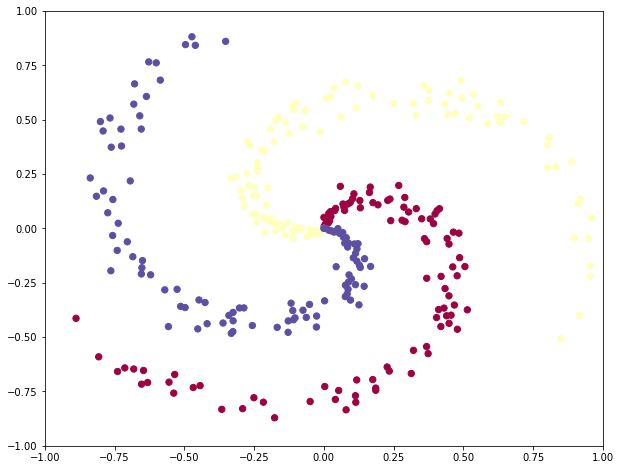

In [2]:
#generate random data -- not linearly separable 
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [3]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0,x)

In [ ]:
# plotting sigmoid function
x = range (-100,100)
y = []

for i in x:
    y.append(sigmoid(i))
      
plt.figure(figsize=(7,7))
plt.plot(np.array(x),np.array(y))
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.title('sigmoid function', fontsize=20)

In [ ]:
# plotting derivative of sigmoid function
y_grad = []

for i in x:
    y_grad.append(sigmoid_grad(i))

plt.figure(figsize=(7,7))
plt.plot(np.array(x),np.array(y_grad))

plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.title('sigmoid function derivative', fontsize=20)

In [4]:
#function to train a three layer neural net with either RELU or sigmoid nonlinearity via vanilla grad descent

def three_layer_net(NONLINEARITY,X,y, model, step_size, reg):
    #parameter initialization
    
    h= model['h']
    h2= model['h2']
    W1= model['W1']
    W2= model['W2']
    W3= model['W3']
    b1= model['b1']
    b2= model['b2']
    b3= model['b3']
    
    
    # some hyperparameters


    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1=[]
    plot_array_2=[]
    for i in xrange(50000):

        #FOWARD PROP

        if NONLINEARITY== 'RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples

 
        # BACKPROP HERE
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)


        if NONLINEARITY == 'RELU':

            #backprop ReLU nonlinearity here
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 =  np.dot( hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':

            #backprop sigmoid nonlinearity here
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)

        
        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)

        # add regularization
        dW3+= reg * W3
        dW2 += reg * W2
        dW1 += reg * W1
        
        #option to return loss, grads -- uncomment next comment
        grads={}
        grads['W1']=dW1
        grads['W2']=dW2
        grads['W3']=dW3
        grads['b1']=db1
        grads['b2']=db2
        grads['b3']=db3
        #return loss, grads
        
        
        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print 'training accuracy: %.2f' % (np.mean(predicted_class == y))  
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

In [5]:
#Initialize toy model, train sigmoid net

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h=50
h2=50
num_train_examples = X.shape[0]

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.156405
iteration 1000: loss 1.100737
iteration 2000: loss 0.999698
iteration 3000: loss 0.855495
iteration 4000: loss 0.819427
iteration 5000: loss 0.814825
iteration 6000: loss 0.810526
iteration 7000: loss 0.805943
iteration 8000: loss 0.800688
iteration 9000: loss 0.793976
iteration 10000: loss 0.783201
iteration 11000: loss 0.759909
iteration 12000: loss 0.719792
iteration 13000: loss 0.683194
iteration 14000: loss 0.655847
iteration 15000: loss 0.634996
iteration 16000: loss 0.618527
iteration 17000: loss 0.602246
iteration 18000: loss 0.579710
iteration 19000: loss 0.546264
iteration 20000: loss 0.512831
iteration 21000: loss 0.492403
iteration 22000: loss 0.481854
iteration 23000: loss 0.475923
iteration 24000: loss 0.472031
iteration 25000: loss 0.469086
iteration 26000: loss 0.466611
iteration 27000: loss 0.464386
iteration 28000: loss 0.462306
iteration 29000: loss 0.460319
iteration 30000: loss 0.458398
iteration 31000: loss 0.456528
iteration 32000: loss

In [ ]:
#Re-initialize model, train relu net

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

## The Vanishing Gradient Issue¶

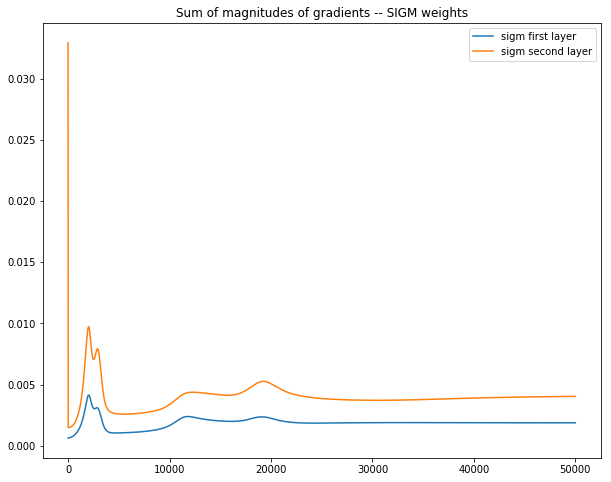

In [6]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

In [ ]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

In [ ]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

In [ ]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())